# 推論單張照片(只能使用GPU)

In [113]:
import torch
from timm.models import create_model
import models_mamba
import torch
import timm
import torchvision
import torchvision.transforms as T
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 導入模型

In [114]:
model = create_model(
        model_name="vim_tiny_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2",
        pretrained=False,
        num_classes=100,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        img_size=224
    )
model = model.to(device)
model.eval()

VisionMamba(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (head): Linear(in_features=192, out_features=100, bias=True)
  (drop_path): Identity()
  (layers): ModuleList(
    (0-23): 24 x Block(
      (mixer): Mamba(
        (in_proj): Linear(in_features=192, out_features=768, bias=False)
        (conv1d): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
        (act): SiLU()
        (x_proj): Linear(in_features=384, out_features=44, bias=False)
        (dt_proj): Linear(in_features=12, out_features=384, bias=True)
        (conv1d_b): Conv1d(384, 384, kernel_size=(4,), stride=(1,), padding=(3,), groups=384)
        (x_proj_b): Linear(in_features=384, out_features=44, bias=False)
        (dt_proj_b): Linear(in_features=12, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=192, bias=False)
      )
      (norm

In [115]:
checkpoint = torch.load('/workspace/Vim/vim/output/test_mini_imnet/best_checkpoint.pth')
model.load_state_dict(checkpoint['model'], strict=False)


<All keys matched successfully>

## 資料集類別映射(IMAGE NET -> MINI IMAGE NET)

因為dataset中資料夾的名稱是以編號作為紀錄，因此要寫一個映射用的字典來顯示結果

In [116]:
import os
folder_path = '/workspace/Vim/dataset/MiniImagenet'
subfolders = [os.path.basename(f.path) for f in os.scandir(folder_path) if f.is_dir()]
print(f"subfolder len :{len(subfolders)}")
print(subfolders)

subfolder len :100
['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01770081', 'n01843383', 'n01855672', 'n01910747', 'n01930112', 'n01981276', 'n02074367', 'n02089867', 'n02091244', 'n02091831', 'n02099601', 'n02101006', 'n02105505', 'n02108089', 'n02108551', 'n02108915', 'n02110063', 'n02110341', 'n02111277', 'n02113712', 'n02114548', 'n02116738', 'n02120079', 'n02129165', 'n02138441', 'n02165456', 'n02174001', 'n02219486', 'n02443484', 'n02457408', 'n02606052', 'n02687172', 'n02747177', 'n02795169', 'n02823428', 'n02871525', 'n02950826', 'n02966193', 'n02971356', 'n02981792', 'n03017168', 'n03047690', 'n03062245', 'n03075370', 'n03127925', 'n03146219', 'n03207743', 'n03220513', 'n03272010', 'n03337140', 'n03347037', 'n03400231', 'n03417042', 'n03476684', 'n03527444', 'n03535780', 'n03544143', 'n03584254', 'n03676483', 'n03770439', 'n03773504', 'n03775546', 'n03838899', 'n03854065', 'n03888605', 'n03908618', 'n03924679', 'n03980874', 'n03998194', 'n04067472', 'n04146614', 'n041

In [117]:
# map class name to class index
with open('../dataset/imnet_clsloc.txt') as f:
    classes = {line.strip().split(' ')[0]: line.strip().split(' ')[2] for line in f.readlines() if line.strip().split(' ')[0] in subfolders}
print(classes)

{'n02110063': 'malamute', 'n02089867': 'Walker_hound', 'n02138441': 'meerkat', 'n02457408': 'three-toed_sloth', 'n02443484': 'black-footed_ferret', 'n02110341': 'dalmatian', 'n02113712': 'miniature_poodle', 'n02111277': 'Newfoundland', 'n02091831': 'Saluki', 'n02108915': 'French_bulldog', 'n02105505': 'komondor', 'n02114548': 'white_wolf', 'n02108551': 'Tibetan_mastiff', 'n02099601': 'golden_retriever', 'n02108089': 'boxer', 'n02101006': 'Gordon_setter', 'n02120079': 'Arctic_fox', 'n02129165': 'lion', 'n02074367': 'dugong', 'n02116738': 'African_hunting_dog', 'n02091244': 'Ibizan_hound', 'n02219486': 'ant', 'n04612504': 'yawl', 'n02981792': 'catamaran', 'n02687172': 'aircraft_carrier', 'n04389033': 'tank', 'n03773504': 'missile', 'n03417042': 'garbage_truck', 'n04509417': 'unicycle', 'n03337140': 'file', 'n07747607': 'orange', 'n13133613': 'ear', 'n03854065': 'organ', 'n04515003': 'upright', 'n03017168': 'chime', 'n03272010': 'electric_guitar', 'n03838899': 'oboe', 'n09246464': 'cliff'

In [118]:
# search for a category
key = 'n02091244' 
if key in classes.keys():
    print(classes[key]) 
else:
    print("Category not found.")

Ibizan_hound


## 開始推論

In [119]:
transform = T.Compose([
    T.Resize(256, interpolation=3),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

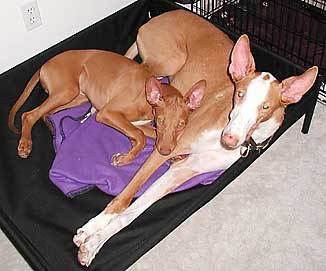

Prediction index 0: Ibizan_hound             , score: 0.066
Prediction index 1: golden_retriever         , score: 0.056
Prediction index 2: crate                    , score: 0.056
Prediction index 3: boxer                    , score: 0.055
Prediction index 4: oboe                     , score: 0.034


In [120]:
from PIL import Image
img = Image.open('/workspace/Vim/dataset/MiniImagenet/n02091244/n02091244_79.JPEG')
display(img)

# transform the original image and add a batch dimension
img = transform(img).unsqueeze(0).to(device)

# compute the predictions
out = model(img)

# and convert them into probabilities
scores = torch.nn.functional.softmax(out, dim=-1)[0]

# finally get the index of the prediction with highest score
topk_scores, topk_label = torch.topk(scores, k=5, dim=-1)

topk_scores, topk_label = topk_scores.to('cpu'), topk_label.to('cpu')


# print the top-5 labels and their scores
for i in range(5):
    pred_name = classes[subfolders[topk_label[i]]]
    print(f"Prediction index {i}: {pred_name:<25}, score: {topk_scores[i]:.3f}")

## 評估指標

[{'train_lr': 1.0000000000000156e-06, 'train_loss': 4.623681969324748, 'test_loss': 4.59168473815918, 'test_acc1': 1.5833334045410157, 'test_acc5': 6.9250001678466795, 'epoch': 0, 'n_parameters': 6974308}, {'train_lr': 1.0000000000000156e-06, 'train_loss': 4.6029776744842525, 'test_loss': 4.5677454414367675, 'test_acc1': 2.5833334217071533, 'test_acc5': 9.850000240325928, 'epoch': 1, 'n_parameters': 6974308}, {'train_lr': 1.330000000000014e-05, 'train_loss': 4.581502288182577, 'test_loss': 4.455300289154053, 'test_acc1': 4.5166668071746825, 'test_acc5': 16.200000507354737, 'epoch': 2, 'n_parameters': 6974308}, {'train_lr': 2.5600000000000334e-05, 'train_loss': 4.552465398788452, 'test_loss': 4.37778271484375, 'test_acc1': 5.450000192642212, 'test_acc5': 18.733333860397337, 'epoch': 3, 'n_parameters': 6974308}, {'train_lr': 3.790000000000037e-05, 'train_loss': 4.530207932154338, 'test_loss': 4.312522935867309, 'test_acc1': 6.25000022315979, 'test_acc5': 20.86666725921631, 'epoch': 4, 'n

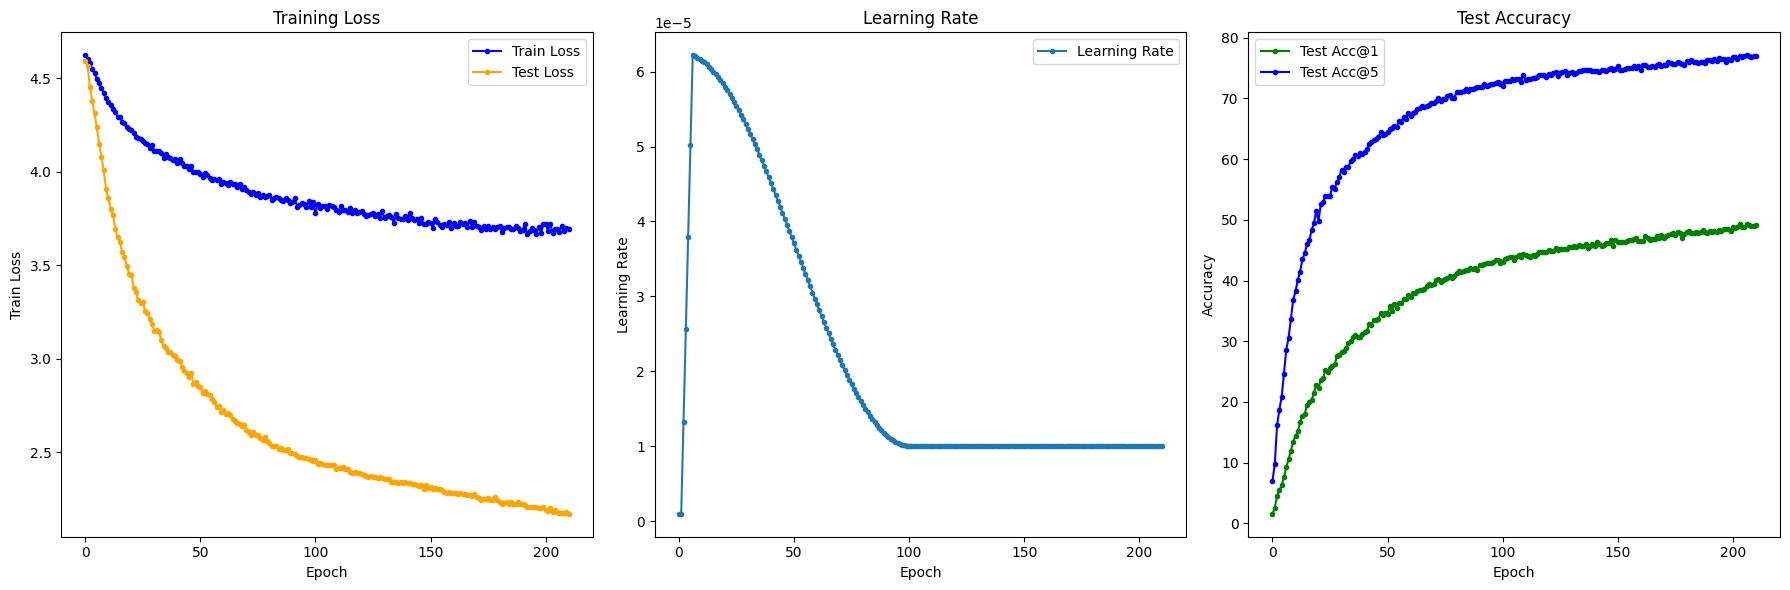

In [134]:
import json
import matplotlib.pyplot as plt

log_path = '/workspace/Vim/vim/output/test_mini_imnet/log.txt'

with open(log_path) as f:
    epoch_data = [json.loads(i) for i in f.readlines()]
    print(epoch_data)
    train_data = [{"train_lr":i["train_lr"],"train_loss":i["train_loss"],"epoch": i["epoch"]} for i in epoch_data]
    test_data = [{"test_loss":i["test_loss"],"test_acc1":i["test_acc1"],"test_acc5": i["test_acc5"],"epoch": i["epoch"]} for i in epoch_data]


# 提取訓練與測試的指標
train_epochs = [entry['epoch'] for entry in train_data]
train_losses = [entry['train_loss'] for entry in train_data]
train_lrs = [entry['train_lr'] for entry in train_data]

test_epochs = [entry['epoch'] for entry in test_data]
test_losses = [entry['test_loss'] for entry in test_data]
test_acc1s = [entry['test_acc1'] for entry in test_data]
test_acc5s = [entry['test_acc5'] for entry in test_data]

# 繪製訓練指標
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_epochs, train_losses, marker='.',  color='blue',label='Train Loss')
plt.plot(test_epochs, test_losses, marker='.', color='orange', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_epochs, train_lrs, marker='.', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(test_epochs, test_acc1s, marker='.', color='green', label='Test Acc@1')
plt.plot(test_epochs, test_acc5s, marker='.', color='blue', label='Test Acc@5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
